# Customer Churn Classification Project

* Sandikha Rahardi (Kuldii Project)
* https://kuldiiproject.com

This notebook demonstrates a complete workflow for customer churn classification using scikit-learn and XGBoost. We will preprocess data, train multiple models, tune hyperparameters, evaluate performance, and compare results.

## 1. Import Required Libraries

Import all necessary libraries for data processing, modeling, and visualization.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

## 2. Load Customer Churn Dataset

The Telco Customer Churn dataset contains customer information and a churn label. We will use this data to build models that predict whether a customer will churn.

In [2]:
# Download Telco Customer Churn dataset from Kaggle if not present
import os
import pandas as pd

if not os.path.exists('WA_Fn-UseC_-Telco-Customer-Churn.csv'):
    # Install kaggle if needed
    try:
        import kaggle
    except ImportError:
        import sys
        !{sys.executable} -m pip install kaggle
    # Set up Kaggle API credentials
    import shutil
    if not os.path.exists(os.path.expanduser('~/.kaggle/kaggle.json')):
        shutil.copy('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
    os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)
    # Download dataset
    !kaggle datasets download -d blastchar/telco-customer-churn --unzip -p .

In [3]:
# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## 3. Exploratory Data Analysis (EDA)

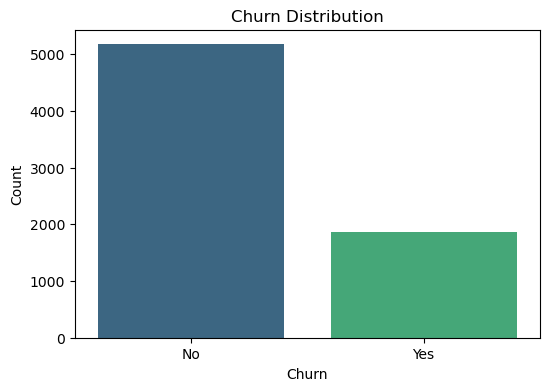

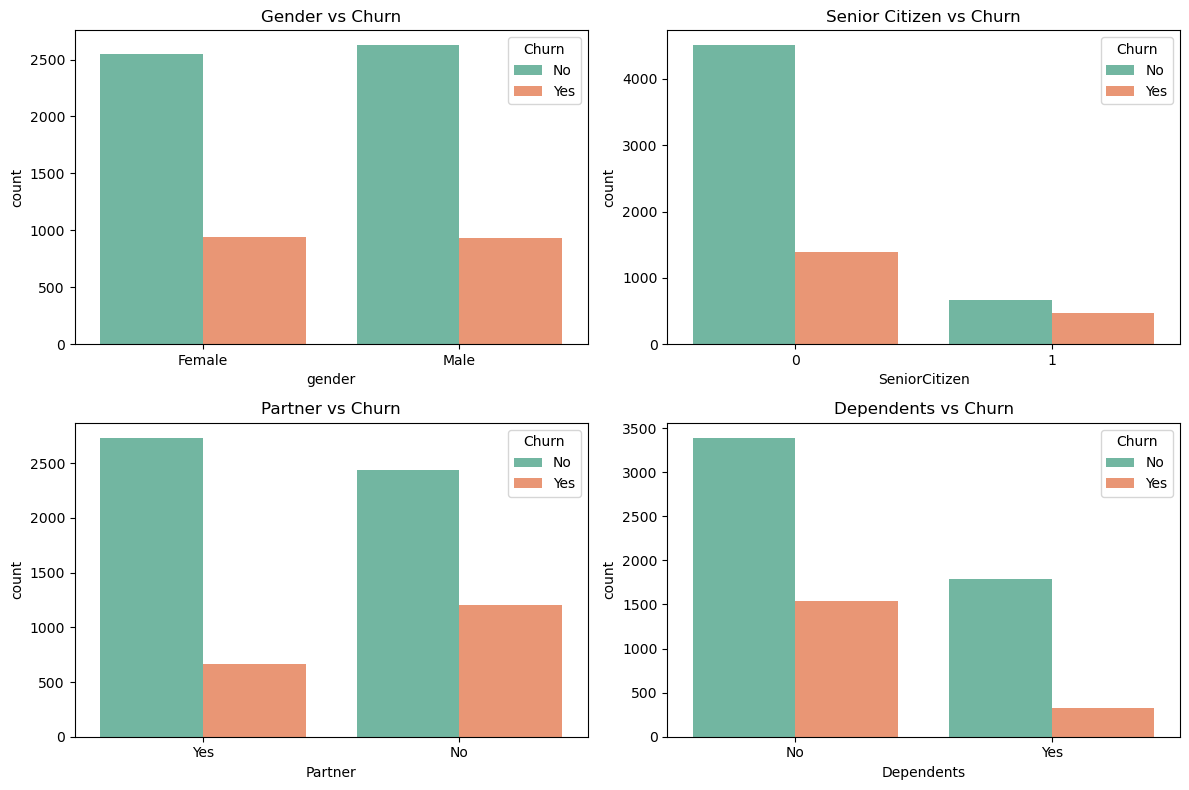

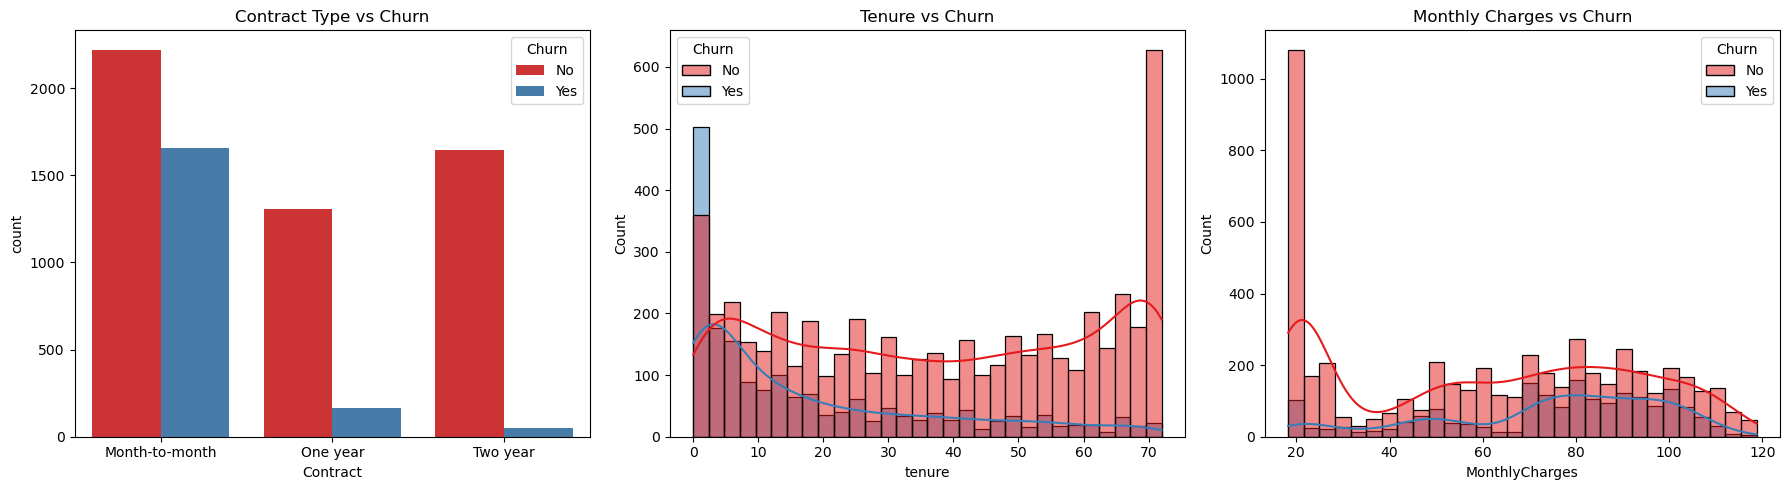

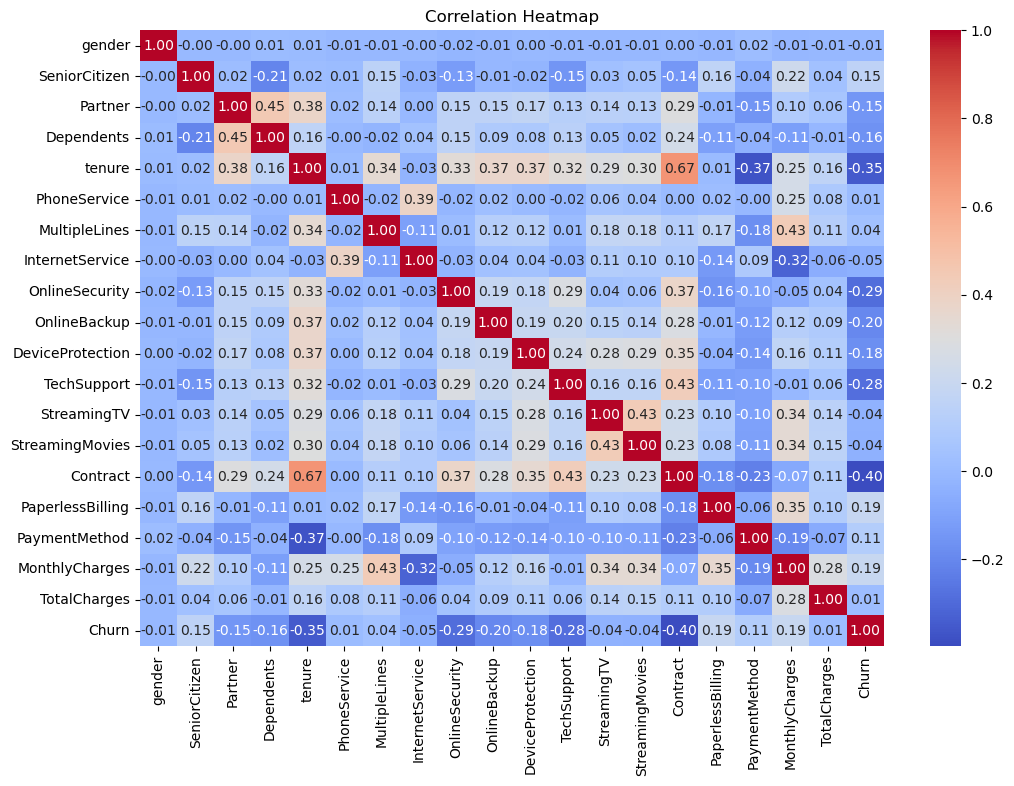

In [4]:
## Churn Distribution
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

## Gender, Senior Citizen, Partner, and Dependents vs Churn
fig, axes = plt.subplots(2, 2, figsize=(12,8))
sns.countplot(ax=axes[0,0], x='gender', hue='Churn', data=df, palette='Set2')
sns.countplot(ax=axes[0,1], x='SeniorCitizen', hue='Churn', data=df, palette='Set2')
sns.countplot(ax=axes[1,0], x='Partner', hue='Churn', data=df, palette='Set2')
sns.countplot(ax=axes[1,1], x='Dependents', hue='Churn', data=df, palette='Set2')
axes[0,0].set_title('Gender vs Churn')
axes[0,1].set_title('Senior Citizen vs Churn')
axes[1,0].set_title('Partner vs Churn')
axes[1,1].set_title('Dependents vs Churn')
plt.tight_layout()
plt.show()
## Contract Type, Tenure, and Charges vs Churn

fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.countplot(ax=axes[0], x='Contract', hue='Churn', data=df, palette='Set1')
sns.histplot(ax=axes[1], x='tenure', hue='Churn', data=df, bins=30, kde=True, palette='Set1')
sns.histplot(ax=axes[2], x='MonthlyCharges', hue='Churn', data=df, bins=30, kde=True, palette='Set1')
axes[0].set_title('Contract Type vs Churn')
axes[1].set_title('Tenure vs Churn')
axes[2].set_title('Monthly Charges vs Churn')
plt.tight_layout()
plt.show()

## Correlation Heatmap
corr_df = df.copy()
corr_df = corr_df.dropna()
# Drop customerID before encoding
if 'customerID' in corr_df.columns:
    corr_df = corr_df.drop('customerID', axis=1)
# Encode categorical variables for correlation
for col in corr_df.select_dtypes(include=['object']).columns:
    corr_df[col] = corr_df[col].astype('category').cat.codes
plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Data Preprocessing for Telco Customer Churn Dataset

In [5]:
# Handle missing values, encode categorical variables, and scale numerical features

def preprocess_telco_data(df):
    df = df.copy()
    # Drop customerID
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)
    # Convert TotalCharges to numeric, coerce errors to NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # Handle missing values
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    # Convert target to binary
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col != 'Churn']
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != 'Churn']
    # Impute missing for numerical (should be none left, but for safety)
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
    # Impute missing for categorical (should be none, but for safety)
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    # Scale numerical features
    scaler = StandardScaler()
    df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])
    # Split features and target
    X = df_encoded.drop('Churn', axis=1)
    y = df_encoded['Churn']
    return X, y, scaler, num_imputer, cat_imputer, categorical_cols, numerical_cols

# Preprocess the Telco dataset
X, y, scaler, num_imputer, cat_imputer, categorical_cols, numerical_cols = preprocess_telco_data(df)
X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.439916,-1.277445,-1.160323,-0.994242,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
1,-0.439916,0.066327,-0.259629,-0.173244,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
2,-0.439916,-1.236724,-0.362660,-0.959674,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,-0.439916,0.514251,-0.746535,-0.194766,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,-0.439916,-1.236724,0.197365,-0.940470,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


## 5. Split Dataset into Training and Testing Sets

Split the preprocessed dataset into training and testing sets using `train_test_split`.

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 5634 samples
Testing set size: 1409 samples


## 6. Define Model Training and Evaluation Functions

Create reusable functions for training models, performing hyperparameter tuning, and evaluating model performance.

In [7]:
def train_and_tune_model(model, param_grid, X_train, y_train, search_type='grid', scoring='roc_auc', cv=5):
    """
    Train and tune a model using GridSearchCV or RandomizedSearchCV.
    Returns the best estimator and the search results.
    """
    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1, verbose=0)
    else:
        search = RandomizedSearchCV(model, param_grid, scoring=scoring, cv=cv, n_iter=20, n_jobs=-1, verbose=0, random_state=42)
    search.fit(X_train, y_train)
    return search.best_estimator_, search

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and return a dictionary of metrics and predictions.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    return metrics

## 7. Train and Tune Logistic Regression

Train a Logistic Regression model, perform hyperparameter tuning, and evaluate its performance.

In [8]:
# Logistic Regression hyperparameter grid
tl_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

logreg_model = LogisticRegression(max_iter=1000, random_state=42)
best_logreg, logreg_search = train_and_tune_model(logreg_model, tl_param_grid, X_train, y_train, search_type='grid')
logreg_metrics = evaluate_model(best_logreg, X_test, y_test)

print("Best Logistic Regression Parameters:", logreg_search.best_params_)
print("Logistic Regression Performance:")
print(f"Accuracy: {logreg_metrics['accuracy']:.3f}")
print(f"Precision: {logreg_metrics['precision']:.3f}")
print(f"Recall: {logreg_metrics['recall']:.3f}")
print(f"F1-score: {logreg_metrics['f1']:.3f}")
print(f"ROC-AUC: {logreg_metrics['roc_auc']:.3f}")

Best Logistic Regression Parameters: {'C': 100, 'solver': 'liblinear'}
Logistic Regression Performance:
Accuracy: 0.801
Precision: 0.647
Recall: 0.548
F1-score: 0.593
ROC-AUC: 0.841


## 8. Train and Tune Random Forest

Train a Random Forest classifier, perform hyperparameter tuning, and evaluate its performance.

In [9]:
# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestClassifier(random_state=42)
best_rf, rf_search = train_and_tune_model(rf_model, rf_param_grid, X_train, y_train, search_type='random')
rf_metrics = evaluate_model(best_rf, X_test, y_test)

print("Best Random Forest Parameters:", rf_search.best_params_)
print("Random Forest Performance:")
print(f"Accuracy: {rf_metrics['accuracy']:.3f}")
print(f"Precision: {rf_metrics['precision']:.3f}")
print(f"Recall: {rf_metrics['recall']:.3f}")
print(f"F1-score: {rf_metrics['f1']:.3f}")
print(f"ROC-AUC: {rf_metrics['roc_auc']:.3f}")

Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}
Random Forest Performance:
Accuracy: 0.806
Precision: 0.671
Recall: 0.529
F1-score: 0.592
ROC-AUC: 0.844


## 9. Train and Tune XGBoost

Train an XGBoost classifier, perform hyperparameter tuning, and evaluate its performance.

In [10]:
# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb, xgb_search = train_and_tune_model(xgb_model, xgb_param_grid, X_train, y_train, search_type='random')
xgb_metrics = evaluate_model(best_xgb, X_test, y_test)

print("Best XGBoost Parameters:", xgb_search.best_params_)
print("XGBoost Performance:")
print(f"Accuracy: {xgb_metrics['accuracy']:.3f}")
print(f"Precision: {xgb_metrics['precision']:.3f}")
print(f"Recall: {xgb_metrics['recall']:.3f}")
print(f"F1-score: {xgb_metrics['f1']:.3f}")
print(f"ROC-AUC: {xgb_metrics['roc_auc']:.3f}")

Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
XGBoost Performance:
Accuracy: 0.796
Precision: 0.654
Recall: 0.495
F1-score: 0.563
ROC-AUC: 0.847


## 10. Train and Tune Support Vector Machine (SVM)

Train a Support Vector Machine classifier, perform hyperparameter tuning, and evaluate its performance.

In [11]:
# SVM hyperparameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_model = SVC(probability=True, random_state=42)
best_svm, svm_search = train_and_tune_model(svm_model, svm_param_grid, X_train, y_train, search_type='grid')
svm_metrics = evaluate_model(best_svm, X_test, y_test)

print("Best SVM Parameters:", svm_search.best_params_)
print("SVM Performance:")
print(f"Accuracy: {svm_metrics['accuracy']:.3f}")
print(f"Precision: {svm_metrics['precision']:.3f}")
print(f"Recall: {svm_metrics['recall']:.3f}")
print(f"F1-score: {svm_metrics['f1']:.3f}")
print(f"ROC-AUC: {svm_metrics['roc_auc']:.3f}")

Best SVM Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Performance:
Accuracy: 0.788
Precision: 0.617
Recall: 0.529
F1-score: 0.570
ROC-AUC: 0.827


## 11. Evaluate and Compare Model Performance

Compare all models using accuracy, precision, recall, F1-score, and ROC-AUC metrics.

In [17]:
# Collect all metrics for comparison
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM']
metrics_list = [logreg_metrics, rf_metrics, xgb_metrics, svm_metrics]

summary = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [m['accuracy'] for m in metrics_list],
    'Precision': [m['precision'] for m in metrics_list],
    'Recall': [m['recall'] for m in metrics_list],
    'F1-score': [m['f1'] for m in metrics_list],
    'ROC-AUC': [m['roc_auc'] for m in metrics_list]
})

summary = summary.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
display(summary)

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,XGBoost,0.796309,0.653710,0.494652,0.563166,0.846856
1,Random Forest,0.806246,0.671186,0.529412,0.591928,0.843874
2,Logistic Regression,0.800568,0.646688,0.548128,0.593343,0.840719
3,SVM,0.787793,0.616822,0.529412,0.569784,0.827194


## 12. Plot Confusion Matrices

Plot confusion matrices for each model to visualize classification performance.

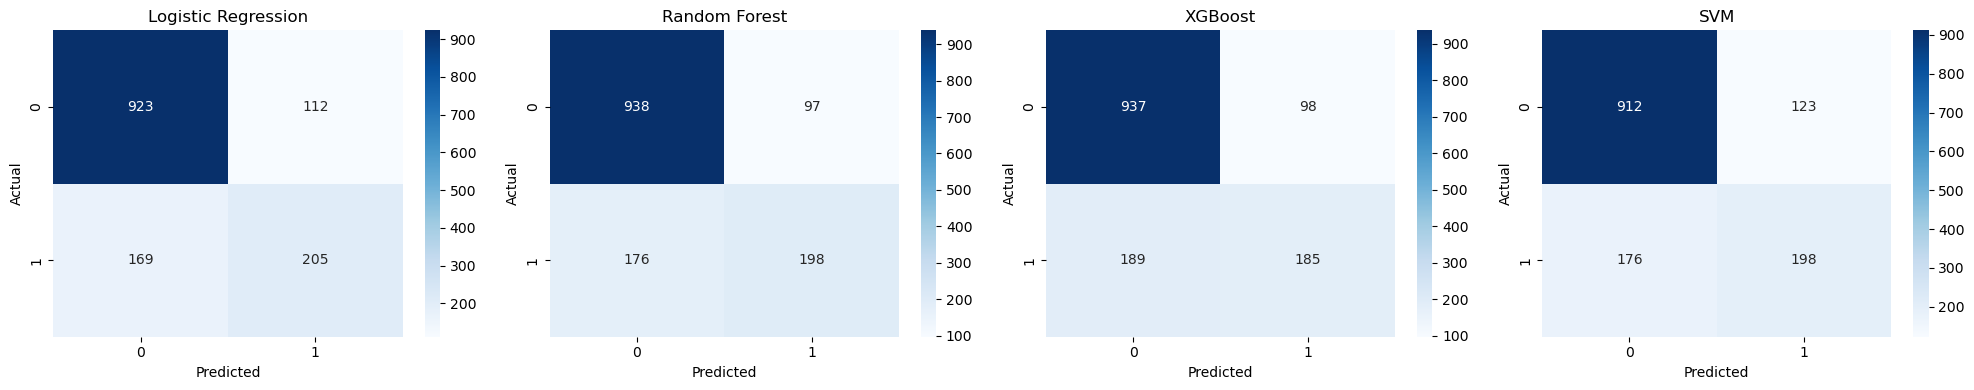

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for idx, (name, metrics) in enumerate(zip(model_names, metrics_list)):
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.show()

## 13. Plot ROC Curves

Plot ROC curves for all models to compare their ability to distinguish between classes.

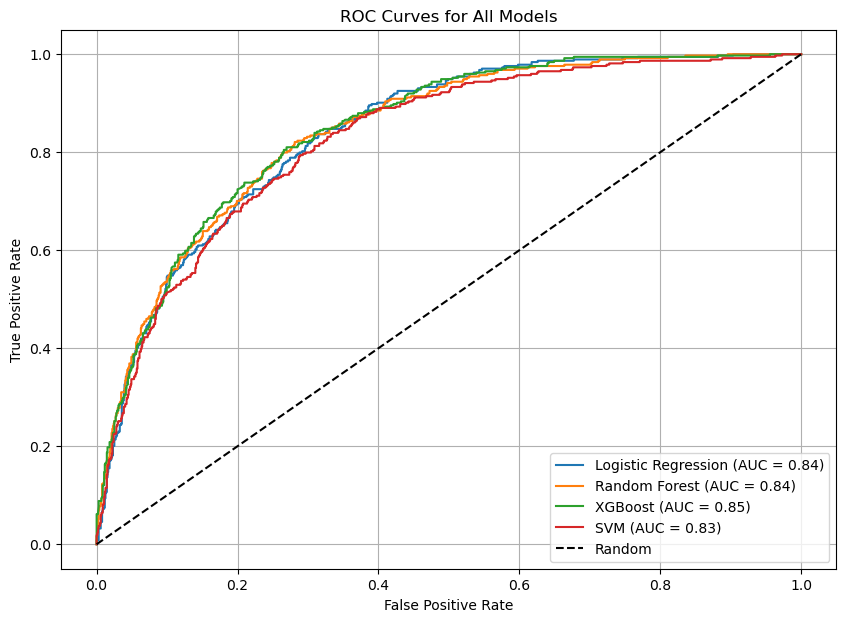

In [19]:
plt.figure(figsize=(10, 7))
for name, metrics in zip(model_names, metrics_list):
    fpr, tpr, _ = roc_curve(y_test, metrics['y_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()

## 14. Interactive Model Testing with Gradio

Use Gradio to create a simple web interface for testing the best model with custom input values.

In [23]:
import gradio as gr
import pandas as pd

def predict_telco_churn_blocks(selected_model, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges):
    input_dict = {
        'gender': gender,
        'SeniorCitizen': 1 if SeniorCitizen == 'Yes' else 0,
        'Partner': Partner,
        'Dependents': Dependents,
        'tenure': tenure,
        'PhoneService': PhoneService,
        'MultipleLines': MultipleLines,
        'InternetService': InternetService,
        'Contract': Contract,
        'PaperlessBilling': PaperlessBilling,
        'PaymentMethod': PaymentMethod,
        'MonthlyCharges': MonthlyCharges,
        'TotalCharges': TotalCharges
    }
    input_df = pd.DataFrame([input_dict])
    for col in numerical_cols:
        if col not in input_df:
            input_df[col] = 0
    for col in categorical_cols:
        if col not in input_df:
            input_df[col] = 'No'
    input_df[numerical_cols] = num_imputer.transform(input_df[numerical_cols])
    input_df[categorical_cols] = cat_imputer.transform(input_df[categorical_cols])
    input_encoded = pd.get_dummies(input_df, columns=categorical_cols, drop_first=True)
    for col in X.columns:
        if col not in input_encoded:
            input_encoded[col] = 0
    input_encoded = input_encoded[X.columns]
    input_encoded[numerical_cols] = scaler.transform(input_encoded[numerical_cols])
    model = {'Logistic Regression': best_logreg, 'Random Forest': best_rf, 'XGBoost': best_xgb, 'SVM': best_svm}[selected_model]
    try:
        proba = model.predict_proba(input_encoded)[0, 1] if hasattr(model, 'predict_proba') else model.decision_function(input_encoded)[0]
        pred = model.predict(input_encoded)[0]
    except Exception as e:
        return f"Error: {str(e)}"
    pred_text = 'Churn' if pred == 1 else 'No Churn'
    return f"🔮 Churn Probability: {proba:.2%}\n\n✅ Prediction: {pred_text}"

with gr.Blocks() as demo:
    gr.Markdown("""
    <h2>📊 Telco Customer Churn Prediction</h2>
    <p style="font-size: 16px;">
    Built with Scikit-learn, XGBoost & Gradio — by Kuldii Project
    </p>
    <p style="font-size: 14px;">
    This app predicts the probability of customer churn for a Telco company based on:<br>
    💁‍♂️ Demographic features<br>
    📞 Service details<br>
    💵 Billing information<br>
    <br>
    Select your desired model below and fill in customer details, then hit Predict!
    </p>
    """)
    
    model_choice = gr.Dropdown(
        choices=model_names,
        label="✨ Select Model",
        value=model_names[0]
    )

    with gr.Row():
        gender = gr.Dropdown(['Female', 'Male'], label='👤 Gender', value='Female')
        SeniorCitizen = gr.Dropdown(['No', 'Yes'], label='🎂 Senior Citizen', value='No')
        Partner = gr.Dropdown(['No', 'Yes'], label='❤️ Has Partner', value='No')
        Dependents = gr.Dropdown(['No', 'Yes'], label='👶 Has Dependents', value='No')

    with gr.Row():
        tenure = gr.Number(label='⏳ Tenure (months)', value=12, minimum=0, maximum=80)
        PhoneService = gr.Dropdown(['No', 'Yes'], label='📞 Phone Service', value='Yes')
        MultipleLines = gr.Dropdown(['No phone service', 'No', 'Yes'], label='📱 Multiple Lines', value='No')
        InternetService = gr.Dropdown(['DSL', 'Fiber optic', 'No'], label='🌐 Internet Service', value='DSL')

    with gr.Row():
        Contract = gr.Dropdown(['Month-to-month', 'One year', 'Two year'], label='📝 Contract', value='Month-to-month')
        PaperlessBilling = gr.Dropdown(['No', 'Yes'], label='🧾 Paperless Billing', value='Yes')
        PaymentMethod = gr.Dropdown([
            'Electronic check', 'Mailed check',
            'Bank transfer (automatic)', 'Credit card (automatic)'
        ], label='💳 Payment Method', value='Electronic check')
        MonthlyCharges = gr.Number(label='💲 Monthly Charges', value=70, minimum=0)
        TotalCharges = gr.Number(label='💰 Total Charges', value=1400, minimum=0)

    predict_btn = gr.Button("🚀 Predict Churn")
    output = gr.Textbox(label="🔎 Prediction Result")

    predict_btn.click(
        fn=predict_telco_churn_blocks,
        inputs=[
            model_choice, gender, SeniorCitizen, Partner, Dependents,
            tenure, PhoneService, MultipleLines, InternetService,
            Contract, PaperlessBilling, PaymentMethod,
            MonthlyCharges, TotalCharges
        ],
        outputs=output
    )

demo.launch(share=False)


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


## 15. Save Trained Models and Preprocessors

Save all trained models and preprocessors to `models/churn_models.pkl` using joblib, for easy reuse in other scripts or apps.

In [21]:
# Save all trained models and preprocessors for later use
def save_churn_models():
    import joblib
    import os
    artifacts = {
        'best_logreg': best_logreg,
        'best_rf': best_rf,
        'best_xgb': best_xgb,
        'best_svm': best_svm,
        'scaler': scaler,
        'num_imputer': num_imputer,
        'cat_imputer': cat_imputer,
        'categorical_cols': categorical_cols,
        'numerical_cols': numerical_cols,
        'X_columns': X.columns.tolist(),
    }
    os.makedirs('models', exist_ok=True)
    joblib.dump(artifacts, 'models/churn_models.pkl')
    print('✅ Models and preprocessors saved to models/churn_models.pkl')

# Call this function after all models are trained
save_churn_models()

✅ Models and preprocessors saved to models/churn_models.pkl
